In [1]:
###############################
# Imports
###############################
import copy
import tempfile

import torch
from torch import multiprocessing

from tensordict import TensorDictBase
from tensordict.nn import TensorDictModule, TensorDictSequential

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer
from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators
from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder
from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)
from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from matplotlib import pyplot as plt
from tqdm import tqdm

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device("cpu"))
print(device)

cpu


In [2]:
###############################
# Hyperparams
###############################

# Seed
seed = 0
torch.manual_seed(seed)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 1000  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Stop training evaders at a point
iteration_when_stop_training_evaders = n_iters // 2

# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of target network

In [3]:
###############################
# Environment Setup
###############################
max_steps = 100  # Environment steps before done

n_chasers = 2
n_evaders = 1
n_obstacles = 2
render = "" # '' or 'human'

# Number of vectorized environments. frames_per_batch collection will be divided among these environments
use_vmas = True
num_vmas_envs = (frames_per_batch // max_steps) 

base_env = VmasEnv(
    scenario="simple_tag",
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    seed=seed,
    # Agents and landmarks
    num_good_agents=n_evaders,
    num_adversaries=n_chasers,
    num_landmarks=n_obstacles,
    # render_mode=render,
)
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)
check_env_specs(env)

2024-12-13 15:05:31,654 [torchrl][INFO] check_env_specs succeeded!


In [4]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 5, 2, 14]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10, 5, 2]),
            device=cpu,
            is_shared=False),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([10, 5, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 5, 1, 12]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size(

In [5]:
###############################
# 1) Define neural network
###############################
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=4,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap policy_net into a dict, to easily retrieve inputs and outputs of neural network. 
    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )

    policy_modules[group] = policy_module

###############################
# 2) ProbabilisticActor
# Build TanhDelta out of policy action. 
###############################
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
             "low": env.full_action_spec[group, "action"].space.low,
             "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

###############################
# 3) ExplorationPolicy
###############################
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

###############################
# Critic Network
###############################
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=4,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [6]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                obs_action: Tensor(shape=torch.Size([10, 2, 16]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 2, 14]), device=cpu, dtype=torch.float32, is_shared=False),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10, 2]),
            device=cpu,
            is_shared=False),
        agent: TensorDict(
            fields={
                episode_re

In [7]:
###############################
# Data Collector
###############################
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

###############################
# Replay Buffer
###############################
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            memory_size, device=device
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=train_batch_size,  # We will sample batches of this size
    )
    if device.type != "cpu":
        replay_buffer.append_transform(lambda x: x.to(device))
    replay_buffers[group] = replay_buffer

###############################
# Loss Function
###############################
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

In [8]:
###############################
# Training Util
###############################
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

In [9]:
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

In [10]:
###############################
# Training Loop
###############################
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Stop training a certain group when a condition is met (e.g., number of training iterations)
    if iteration == iteration_when_stop_training_evaders:
        del train_group_map["agent"]

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_adversary = 11.0, episode_reward_mean_agent = -11.0: 100%|██████████| 1000/1000 [46:37<00:00,  2.23s/it] 

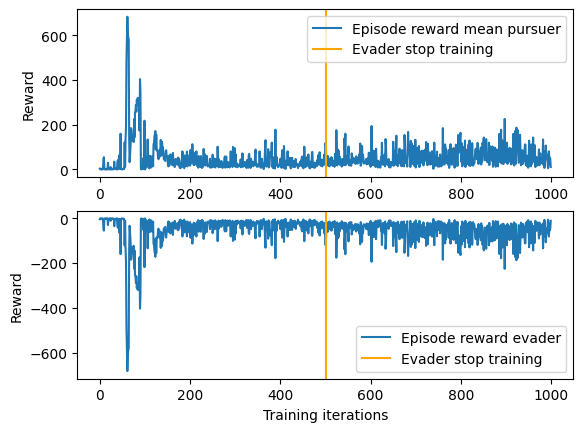

In [11]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    groupStr = 'evader' if group=='agent' else 'mean pursuer'

    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward {groupStr}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_evaders,
        label="Evader stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

In [76]:
# # Save models

# import os

# # Directory to save models
# save_dir = "3layer_500iter"
# os.makedirs(save_dir, exist_ok=True)

# # Save policy networks
# for group, policy_module in policy_modules.items():
#     torch.save(policy_module.state_dict(), os.path.join(save_dir, f"policy_module_{group}.pth"))

# # Save exploration policies
# for group, exploration_policy in exploration_policies.items():
#     torch.save(exploration_policy.state_dict(), os.path.join(save_dir, f"exploration_policy_{group}.pth"))

# # Save critic networks
# for group, critic in critics.items():
#     torch.save(critic.state_dict(), os.path.join(save_dir, f"critic_{group}.pth"))


In [ ]:
# import os
# save_dir = "saved_models"

# # Load policy modules
# for group, policy_module in policy_modules.items():
#     policy_module.load_state_dict(torch.load(os.path.join(save_dir, f"policy_module_{group}.pth")))

# # Load exploration policies
# for group, exploration_policy in exploration_policies.items():
#     exploration_policy.load_state_dict(torch.load(os.path.join(save_dir, f"exploration_policy_{group}.pth")))

# # Load critic networks
# for group, critic in critics.items():
#     critic.load_state_dict(torch.load(os.path.join(save_dir, f"critic_{group}.pth")))


C:\Users\dfc49\AppData\Local\Temp\ipykernel_10180\3544414035.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_module.load_state_dict(torch.load(os.path.join(save_d

In [ ]:
import time
tmp_dir = "/mydir"

if use_vmas:
    # Replace tmpdir with any desired path where the video should be saved
    with tempfile.TemporaryDirectory() as tmpdir:
        video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
        print("Creating rendering env")
        env_with_render = TransformedEnv(env.base_env, env.transform.clone())
        env_with_render = env_with_render.append_transform(
            PixelRenderTransform(
                out_keys=["pixels"],
                # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
                preproc=lambda x: x.copy(),
                as_non_tensor=True,
                # asking for array rather than on-screen rendering
                mode="rgb_array",
            )
        )
        env_with_render = env_with_render.append_transform(
            VideoRecorder(logger=video_logger, tag="vmas_rendered")
        )
        with set_exploration_type(ExplorationType.DETERMINISTIC):
            print("Rendering rollout...")
            env_with_render.rollout(100, policy=agents_exploration_policy)
            print(f"Temporary directory path: {tmpdir}")
            print("Saving the video...")
            env_with_render.transform.dump()
            print("Saved! Saved directory tree:")
            video_logger.print_log_dir()
            time.sleep(1000)

Creating rendering env
Rendering rollout...
Temporary directory path: C:\Users\dfc49\AppData\Local\Temp\tmpu5d8m7hw
Saving the video...


2024-12-13 15:04:49,668 [tensordict][INFO] Directory size: 118.40 KB
2024-12-13 15:04:49,668 [tensordict][INFO] tmpu5d8m7hw/
2024-12-13 15:04:49,669 [tensordict][INFO]     vmas_logs/
2024-12-13 15:04:49,669 [tensordict][INFO]         scalars/
2024-12-13 15:04:49,670 [tensordict][INFO]         texts/
2024-12-13 15:04:49,671 [tensordict][INFO]         videos/
2024-12-13 15:04:49,671 [tensordict][INFO]             vmas_rendered_0.mp4


Saved! Saved directory tree:
